# Foreign Student Mental Health ML

This project uses machine learning techniques to learn about influences on mental health of international and domestic students at Ritsumeikan Asia Pacific University in Japan and aims to build a model to predict students at risk of mental health issues such as depression and suicidal ideation.

Notes on the data
* Two of the international students have country of origin as Japan, meaning they lived abroad and then applied to the university as an international student. These students were regarded as international in the analysis.

## Notebook WIP Notes
This cell contains notes and todos on the progress of this project for reference purposes, and is intended for deletion when the notebook is complete.

**Progress Outside of Notebook**
* Codebook Excel corrected so that it is consistent with the actual data, by using value_counts to observe actual values of cat cols.


**TODO, IMMEDIATE:**
* Include the numeric and categorical TARGETS in the dtype correcting and checking step (alongside the features)

**TODO (non-immediate):**
* Add a link to the readme and the top of this notebook for downloading the actual data (to show I didn't edit it)

## 1. Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# ML imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from sklearn.dummy import DummyRegressor, DummyClassifier


from sklearn.inspection import permutation_importance
import xgboost as xgb
import shap

# Other
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from pandas.api.types import is_numeric_dtype

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# File paths
DATA_PATH = Path("../data/data.csv")
CODEBOOK_PATH = Path("../data/feature_target_explanations.xlsx")

# Toggles
INCLUDE_FSCORE2 = False  # set True to include feature-score == 2 variables
# FLAGGING FOR LATER: Consider removing
SHAP_SAMPLE_N = 300  # sample size for SHAP
SHAP_TOP_K = 5  # how many top features to explain with SHAP

## 2. Data Prep and Cleaning

### Quick file existence check and preview

In [2]:
print("Data exists:", DATA_PATH.exists())
print("Codebook exists:", CODEBOOK_PATH.exists())

data = pd.read_csv(DATA_PATH)
print("Data shape:", data.shape)
display(data.head())

Data exists: True
Codebook exists: True
Data shape: (268, 50)


,inter_dom,Region,Gender,Academic,Age,Age_cate,Stay,Stay_Cate,Japanese,Japanese_cate,...,Friends_bi,Parents_bi,Relative_bi,Professional_bi,Phone_bi,Doctor_bi,religion_bi,Alone_bi,Others_bi,Internet_bi
0,Inter,SEA,Male,Grad,24,4,5,Long,3,Average,...,Yes,Yes,No,No,No,No,No,No,No,No
1,Inter,SEA,Male,Grad,28,5,1,Short,4,High,...,Yes,Yes,No,No,No,No,No,No,No,No
2,Inter,SEA,Male,Grad,25,4,6,Long,4,High,...,No,No,No,No,No,No,No,No,No,No
3,Inter,EA,Female,Grad,29,5,1,Short,2,Low,...,Yes,Yes,Yes,Yes,No,No,No,No,No,No
4,Inter,EA,Female,Grad,28,5,1,Short,1,Low,...,Yes,Yes,No,Yes,No,Yes,Yes,No,No,No


### Load codebook and inspect - is this necessary?

In [3]:
cb_numeric = pd.read_excel(CODEBOOK_PATH, sheet_name="numeric_variables")
cb_categorical = pd.read_excel(CODEBOOK_PATH, sheet_name="cat_variables")
display(cb_numeric.head())
display(cb_categorical.head())

,Coded Name,Feature Score,Target Score,Filter Score,Explanation,Unit,Mean,Min,Max,Standard Deviation
0,Age,3,0,2,Current age of students,Year,20.87,17,31,2.77
1,Stay,3,0,2,How long they have been in the university,Year,2.15,1,10,1.33
2,Japanese,3,0,2,Self-evaluation scale ranging from 1 to 5 rega...,Count,3.10,1,5,1.31
3,English,3,0,2,Self-evaluation scale ranging from 1 to 5 rega...,Count,3.65,1,5,0.88
4,ToDep,0,3,1,Total score of depression measured by PHQ-9,Count,8.19,0,25,4.95


,Coded Name,Numeric Version Exists,Feature Score,Target Score,Filter Score,Explanation,Possible Values
0,inter_dom,N,3,0,3,Types of students: International student (Inte...,"Inter, Dom"
1,Region,N,1,0,2,Regions where students originally come from: J...,"JAP, EA, SA, SEA, Others"
2,Gender,N,3,0,1,Gender of students: Male or Female,"Male, Female"
3,Academic,N,3,0,1,The current academic level of students: Underg...,"Under, Grad"
4,Age_cate,Y,3,0,1,The age group of students at time of taking th...,"1, 2, 3, 4, 5"


### Rename and define targets

Rename the targets to improve clarity.

In [4]:
# OLD VERSION OF TARGETS:
# TARGETS = {"depression": "ToDep", "ideation": "Suicide", "acculturative_stress": "ToAS"}

# New target variable names
rename_targets = {
    "ToDep": "depression",
    "Suicide": "suicidal_ideation",
    "ToAS": "acculturative_stress",
}

# Update data columns
data = data.rename(columns=rename_targets)

# Update codebooks
cb_numeric["Coded Name"] = cb_numeric["Coded Name"].replace(rename_targets)
cb_categorical["Coded Name"] = cb_categorical["Coded Name"].replace(rename_targets)

# Define target lists
TARGETS = list(rename_targets.values())

REGRESSION_TARGETS = [
    target for target in rename_targets.values() if target in cb_numeric["Coded Name"].values
]

CLASSIFICATION_TARGETS = [
    target for target in rename_targets.values() if target in cb_categorical["Coded Name"].values
]

print(f"Numeric targets for regression: {len(REGRESSION_TARGETS)}, {REGRESSION_TARGETS}")
print(f"Binary targets for classification: {len(CLASSIFICATION_TARGETS)}, {CLASSIFICATION_TARGETS}")

Numeric targets for regression: 2, ['depression', 'acculturative_stress']
Binary targets for classification: 1, ['suicidal_ideation']


### Clean variable names

In [5]:
def clean_up(input: pd.Index | pd.Series) -> pd.Index | pd.Series:
    """Cleans by stripping whitespace, converting to lowercase,
    and replacing spaces with underscores."""
    return input.str.strip().str.lower().str.replace(" ", "_", regex=False)


# Clean columns in data
data.columns = clean_up(data.columns)

# Clean columns in codebook
cb_numeric.columns = clean_up(cb_numeric.columns)
cb_categorical.columns = clean_up(cb_categorical.columns)

# Clean variables in codebook
cb_numeric["coded_name"] = clean_up(cb_numeric["coded_name"])
cb_categorical["coded_name"] = clean_up(cb_categorical["coded_name"])

### Ensure consistency
Verify that codebook variables match the data column names exactly by symmetric difference "^".

In [6]:
codebook_vars_set = set(cb_numeric["coded_name"]) | set(cb_categorical["coded_name"])
variable_mismatch = set(data.columns) ^ codebook_vars_set
assert (
    len(variable_mismatch) == 0
), f"The following variables mismatch between codebook and data: {variable_mismatch}"

### Aggregate codebook variables for analysis
Only keep categorical variables that do not have a numeric equivalent; numeric versions have higher resolution.

In [7]:
potential_numeric_vars = cb_numeric[["coded_name", "feature_score", "target_score", "filter_score"]]
potential_cat_vars = cb_categorical.loc[
    cb_categorical["numeric_version_exists"] == "N",
    ["coded_name", "feature_score", "target_score", "filter_score"],
]
potential_vars_df = pd.concat([potential_numeric_vars, potential_cat_vars], ignore_index=True)

### Validate stay duration
Define a constraint such that a student's length of stay must be less than or equal to their age minus 16.  
Values violating this constraint are treated as invalid and set to missing.

In [8]:
mask = data["stay"] > (data["age"] - 16)
data.loc[mask, "stay"] = np.nan

### Build feature list based on feature score

NOTE- There are no features with a feature score of 2, so this can be removed and the codebook can be edited to binary for feature candidates e.g. Y/N.

Survey variables were assigned scores indicating their suitability as features, targets, or filtering variables.

Feature scores are based on the survey design and variable definitions, and aim to exclude variables that are likely consequences of a student’s circumstances rather than independent predictors, to avoid conflation with the target variables.

In [9]:
# Include variables with feature_score==3, optionally include feature_score==2 when toggle set
fs3 = set(potential_vars_df.loc[potential_vars_df["feature_score"] == 3, "coded_name"].tolist())
fs2 = set(potential_vars_df.loc[potential_vars_df["feature_score"] == 2, "coded_name"].tolist())
if INCLUDE_FSCORE2:
    FEATURES = list(fs3.union(fs2))
else:
    FEATURES = list(fs3.copy())

# Print features and how many
print("Number of features selected:", len(FEATURES))
print("Features selected:", FEATURES)

Number of features selected: 9
Features selected: ['stay', 'age', 'academic', 'religion', 'inter_dom', 'intimate', 'english', 'japanese', 'gender']


### Split numeric vs binary features and validate data types
All of the categorical features and targets to be used are binary, so map them to 0/1.

[Table of mappings here]

After mapping, all features are numeric:  *FEATURES*

After mapping, all targets are numeric, and are split based on their application:  *REGRESSION_TARGETS* or *CLASSIFICATION_TARGETS*

In [10]:
# Split features based on codebook
BINARY_FEATURES = [c for c in FEATURES if c in cb_categorical["coded_name"].values]

# Map binary features and targets to 0/1
BINARY_MAPPINGS = {
    "gender": {"Female": 0, "Male": 1},
    "inter_dom": {"Dom": 0, "Inter": 1},
    "academic": {"Under": 0, "Grad": 1},
    "intimate": {"No": 0, "Yes": 1},
    "religion": {"No": 0, "Yes": 1},
    "suicidal_ideation": {"No": 0, "Yes": 1},
}
assert set(BINARY_MAPPINGS.keys()) == set(
    BINARY_FEATURES + CLASSIFICATION_TARGETS
), "Binary mapping keys do not match binary features and classification targets"
for col, mapping in BINARY_MAPPINGS.items():
    data[col] = data[col].map(mapping)

# Validate all variables are numeric dtypes
assert all(
    is_numeric_dtype(data[c]) for c in FEATURES + TARGETS
), "One or more numeric features or targets are not numeric dtype"

print(f"Numeric features: {len(FEATURES)}")
print(FEATURES)

Numeric features: 9
['stay', 'age', 'academic', 'religion', 'inter_dom', 'intimate', 'english', 'japanese', 'gender']


### EDA heatmap
Basic missingness and distributions

Students surveyed: 268

Features and targets with missing data:
intimate    3.0% missing
stay        0.7% missing

The remaining 10 features and targets have no missing data.


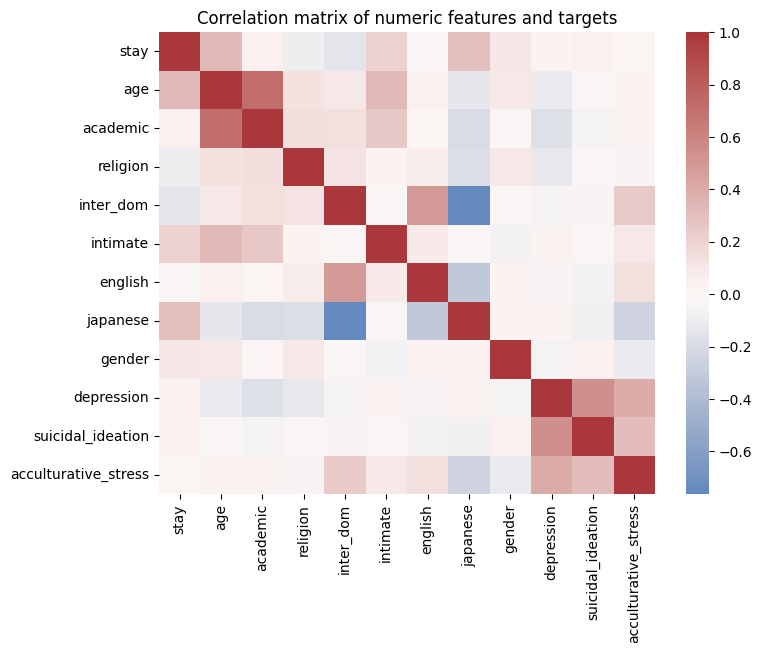

In [11]:
# Summary of missing data
print(f"Students surveyed: {len(data)}")
missing_summary = data[FEATURES + TARGETS].isna().mean().sort_values(ascending=False)
missing_summary = pd.DataFrame(missing_summary, columns=["missing_rate"])
missing_summary["missing"] = missing_summary["missing_rate"].apply(lambda x: f"{x:.1%} missing")

print("\nFeatures and targets with missing data:")
print(missing_summary.loc[missing_summary["missing_rate"] > 0, "missing"].to_string(header=False))
n_none_missing = missing_summary["missing_rate"].eq(0).sum()
print(f"\nThe remaining {n_none_missing} features and targets have no missing data.")

# Correlation heatmap
corr = data[FEATURES + TARGETS].corr().round(3)
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="vlag", center=0, annot=False)
plt.title("Correlation matrix of numeric features and targets")
plt.show()

## 3. Model Building

### Construct preprocessing pipeline
Only numeric, as categorical features were all made into binary numeric features.

Note that all predefined feature names are preserved through preprocessing.

In [12]:
num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])

preprocessor = ColumnTransformer([("num", num_pipe, FEATURES)], remainder="drop")

### VIF function (run after fitting preprocessor)
Variance Inflation Factor (VIF) quantifies how much a regression coefficient’s variance is inflated due to multicollinearity. It is computed as $ 1/(1 - R^2) $, where $ R^2 $ comes from regressing one feature on all others.

In [13]:
def compute_vif(preprocessor, X_df):
    """Compute VIF on preprocessed numeric matrix"""
    X_arr = preprocessor.fit_transform(X_df)
    vif_df = pd.DataFrame(
        {
            "feature": FEATURES,
            "VIF": [variance_inflation_factor(X_arr, i) for i in range(X_arr.shape[1])],
        }
    ).sort_values("VIF", ascending=False)
    return vif_df

### Evaluation utilities
Cross-validation evaluation for regression and classification.

In [14]:
def evaluate_regression_scores(pipe, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    r2 = cross_val_score(pipe, X, y, cv=kf, scoring="r2", n_jobs=-1)
    rmse = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=-1)
    mae = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_absolute_error", n_jobs=-1)
    return {
        "r2_mean": r2.mean(),
        "r2_std": r2.std(),
        "rmse_mean": rmse.mean(),
        "rmse_std": rmse.std(),
        "mae_mean": mae.mean(),
        "mae_std": mae.std(),
    }


def evaluate_classification_scores(pipe, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    roc = cross_val_score(pipe, X, y, cv=skf, scoring="roc_auc", n_jobs=-1)
    # Predict probabilities for PR-AUC
    prob = cross_val_predict(pipe, X, y, cv=skf, method="predict_proba", n_jobs=-1)
    # prob[:,1] exists when pipeline returns classifier with predict_proba
    # compute per-fold PR-AUC manually is expensive; approximate with full P-R curve
    pr, re, _ = precision_recall_curve(y, prob[:, 1])
    #   Look up and understand better what's happening with the p-r auc.
    pr_auc_full = auc(re, pr)
    return {"roc_auc_mean": roc.mean(), "roc_auc_std": roc.std(), "pr_auc": pr_auc_full}

### Model definitions

In [15]:
regressors = {
    "MeanBaseline": DummyRegressor(strategy="mean"),
    "OLS": LinearRegression(),
    "Ridge": Ridge(random_state=RANDOM_STATE),
    "Lasso": Lasso(random_state=RANDOM_STATE),
    "ElasticNet": ElasticNet(random_state=RANDOM_STATE),
    "RF": RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE),
    "XGB": xgb.XGBRegressor(random_state=RANDOM_STATE, verbosity=0),
}

classifiers = {
    "MajorityBaseline": DummyClassifier(strategy="most_frequent"),
    "Logistic": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    # max_iter increased to ensure convergence
    "Logistic_EN": LogisticRegression(
        penalty="elasticnet", solver="saga", l1_ratio=0.5, max_iter=2000, random_state=RANDOM_STATE
    ),  # SAGA solver required for elasticnet
    "RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "XGB": xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, verbosity=0),
}

## 4. Running Models

### RUN MODELS - Depression and acculturative stress (regression)
[Note, completed above this cell 23/01/2026]

In [16]:
data_subsets = {
    "All Data": data,
    "International Only": data[data["inter_dom"] == 1].reset_index(drop=True),
    "Domestic Only": data[data["inter_dom"] == 0].reset_index(drop=True),
}

## Dataset: All Data
---

Regression results for target: depression with 268 samples


,r2_mean,r2_std,rmse_mean,rmse_std,mae_mean,mae_std
MeanBaseline,-0.017,0.018,4.952,0.341,3.862,0.229
OLS,-0.019,0.045,4.955,0.345,3.845,0.252
Ridge,-0.018,0.044,4.954,0.346,3.844,0.252
Lasso,-0.017,0.017,4.952,0.341,3.862,0.229
ElasticNet,-0.004,0.023,4.921,0.349,3.841,0.241
RF,-0.283,0.063,5.569,0.492,4.365,0.317
XGB,-0.903,0.249,6.779,0.837,5.273,0.594


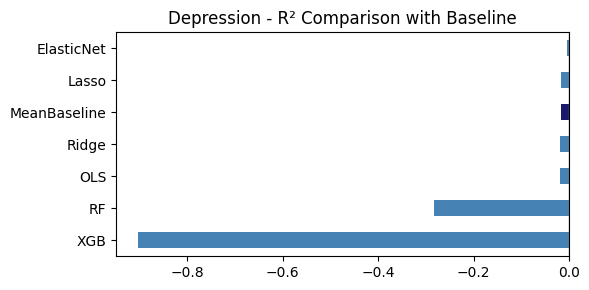

---

Regression results for target: acculturative_stress with 268 samples


,r2_mean,r2_std,rmse_mean,rmse_std,mae_mean,mae_std
MeanBaseline,-0.022,0.022,22.619,1.906,18.518,1.768
OLS,-0.002,0.094,22.379,2.155,18.498,1.864
Ridge,-0.002,0.094,22.372,2.155,18.494,1.863
Lasso,0.008,0.074,22.269,2.004,18.385,1.797
ElasticNet,0.023,0.065,22.108,2.027,18.236,1.800
RF,-0.176,0.072,24.229,1.856,19.358,1.908
XGB,-0.492,0.064,27.307,2.118,21.326,2.131


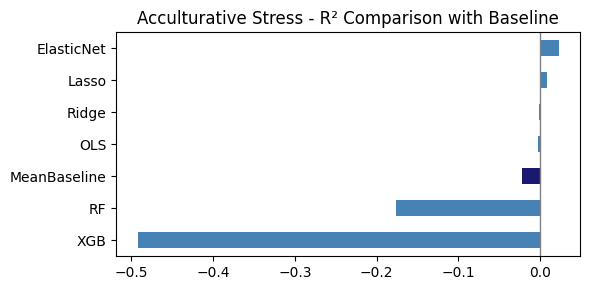

---

## Dataset: International Only
---

Regression results for target: depression with 201 samples


,r2_mean,r2_std,rmse_mean,rmse_std,mae_mean,mae_std
MeanBaseline,-0.023,0.027,4.879,0.549,3.835,0.276
OLS,-0.026,0.034,4.891,0.598,3.830,0.316
Ridge,-0.025,0.033,4.888,0.597,3.827,0.315
Lasso,-0.021,0.029,4.873,0.545,3.833,0.275
ElasticNet,0.002,0.019,4.823,0.565,3.800,0.300
RF,-0.214,0.162,5.300,0.627,4.049,0.338
XGB,-0.661,0.393,6.197,1.060,4.733,0.665


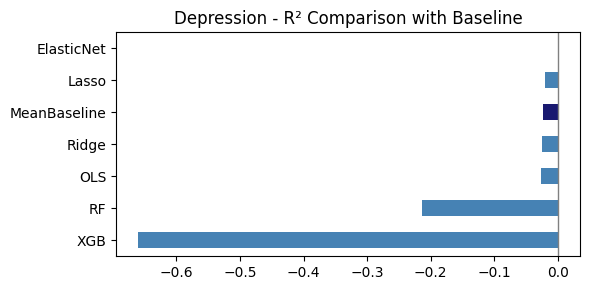

---

Regression results for target: acculturative_stress with 201 samples


,r2_mean,r2_std,rmse_mean,rmse_std,mae_mean,mae_std
MeanBaseline,-0.038,0.027,22.594,1.433,18.417,1.644
OLS,-0.114,0.135,23.373,2.031,19.140,1.470
Ridge,-0.112,0.134,23.357,2.025,19.128,1.469
Lasso,-0.073,0.077,22.972,1.748,18.864,1.577
ElasticNet,-0.055,0.062,22.781,1.629,18.684,1.497
RF,-0.288,0.107,25.156,1.927,20.099,1.387
XGB,-0.771,0.134,29.482,1.902,23.059,1.673


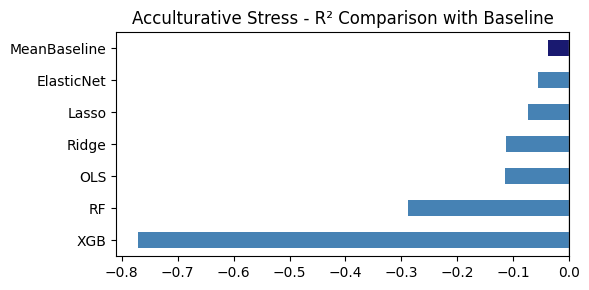

---

## Dataset: Domestic Only
---

Regression results for target: depression with 67 samples


,r2_mean,r2_std,rmse_mean,rmse_std,mae_mean,mae_std
MeanBaseline,-0.077,0.100,5.114,0.442,3.935,0.337
OLS,-0.295,0.156,5.603,0.534,4.395,0.595
Ridge,-0.286,0.154,5.583,0.525,4.379,0.592
Lasso,-0.077,0.100,5.114,0.442,3.935,0.337
ElasticNet,-0.128,0.118,5.229,0.436,4.049,0.409
RF,-0.366,0.349,5.678,0.576,4.514,0.443
XGB,-0.964,0.687,6.728,0.932,5.463,0.475


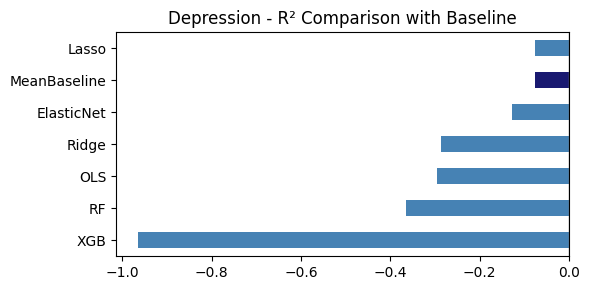

---

Regression results for target: acculturative_stress with 67 samples


,r2_mean,r2_std,rmse_mean,rmse_std,mae_mean,mae_std
MeanBaseline,-0.098,0.120,20.306,2.364,17.262,2.011
OLS,-0.374,0.073,22.670,1.691,19.053,2.056
Ridge,-0.355,0.063,22.513,1.608,18.935,1.915
Lasso,-0.239,0.145,21.517,2.189,17.964,1.890
ElasticNet,-0.199,0.136,21.166,2.088,17.757,1.821
RF,-0.401,0.205,22.938,3.074,18.741,2.936
XGB,-0.626,0.343,24.435,2.881,19.635,3.236


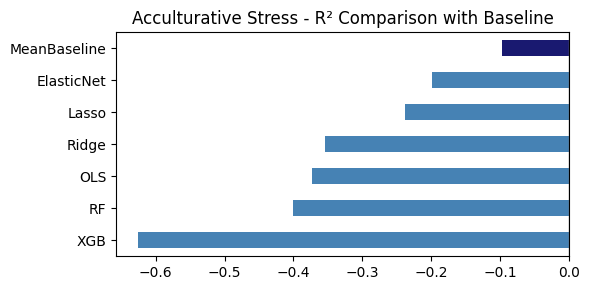

---

In [ ]:
for name, data_i in data_subsets.items():
    display(Markdown(f"## Dataset: {name}\n---"))
    regression_results = {}

    for target in REGRESSION_TARGETS:
        X = data_i[FEATURES].copy()
        y = data_i[target].copy()
        mask = y.notna()  # Mask out missing data for robustness
        X_reg = X.loc[mask].reset_index(drop=True)
        y_reg = y.loc[mask].reset_index(drop=True)
        reg_results_i = {}
        for name, model in regressors.items():
            pipe = Pipeline([("pre", preprocessor), ("model", model)])
            result = evaluate_regression_scores(pipe, X_reg, y_reg, cv=5)
            reg_results_i[name] = result
        regression_results[target] = reg_results_i

    for target, results in regression_results.items():
        print(f"Regression results for target: {target} with {len(y_reg)} samples")
        results_df = pd.DataFrame(results).T
        display(results_df.round(3))

        fig, ax = plt.subplots(figsize=(6, 3))
        results_df = results_df.sort_values("r2_mean")
        colors = [
            "midnightblue" if model == "MeanBaseline" else "steelblue" for model in results_df.index
        ]
        results_df["r2_mean"].plot.barh(ax=ax, color=colors)
        ax.set_title(f"{target.title().replace('_', ' ')}: R² Comparison with Baseline")
        ax.axvline(0, color="grey", linewidth=1)
        plt.tight_layout()
        plt.show()
        plt.close(fig)
        display(Markdown("---"))

### RUN MODELS - Suicidal ideation (classification)

## Dataset: All Data
---

Classification results for target: suicidal_ideation with 268 samples


,roc_auc_mean,roc_auc_std,pr_auc
MajorityBaseline,0.500,0.000,0.614
Logistic,0.525,0.045,0.214
Logistic_EN,0.525,0.044,0.213
RF,0.490,0.084,0.219
XGB,0.513,0.050,0.264


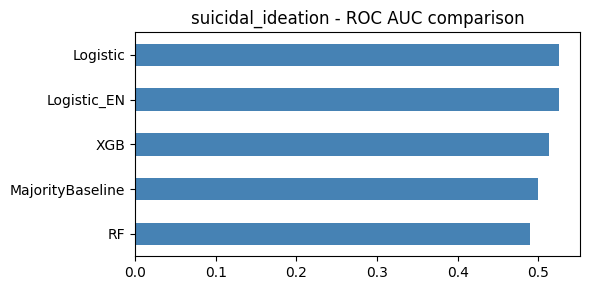

---

## Dataset: International Only
---

Classification results for target: suicidal_ideation with 201 samples


,roc_auc_mean,roc_auc_std,pr_auc
MajorityBaseline,0.500,0.000,0.617
Logistic,0.385,0.086,0.180
Logistic_EN,0.380,0.081,0.180
RF,0.459,0.064,0.229
XGB,0.516,0.026,0.241


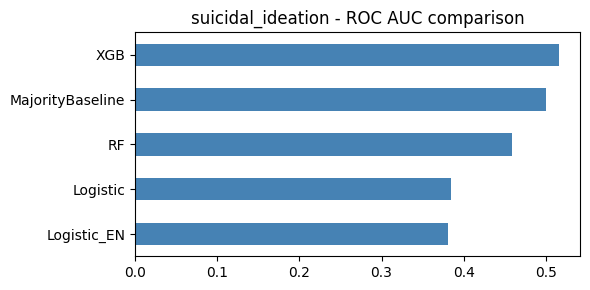

---

## Dataset: Domestic Only
---

Classification results for target: suicidal_ideation with 67 samples


,roc_auc_mean,roc_auc_std,pr_auc
MajorityBaseline,0.500,0.000,0.604
Logistic,0.627,0.190,0.334
Logistic_EN,0.640,0.201,0.340
RF,0.593,0.104,0.433
XGB,0.535,0.122,0.215


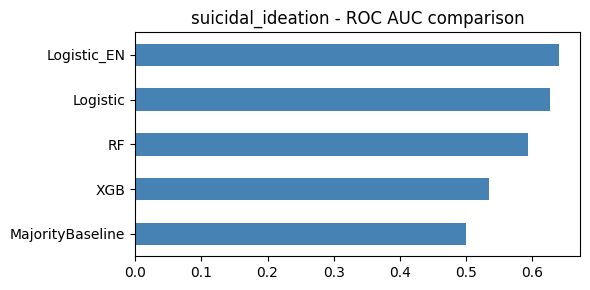

---

In [30]:
for name, data_i in data_subsets.items():
    display(Markdown(f"## Dataset: {name}\n---"))
    classification_results = {}

    for target in CLASSIFICATION_TARGETS:
        X = data_i[FEATURES].copy()
        y = data_i[target].copy()
        mask = y.notna()  # Mask out missing data for robustness
        X_clf = X.loc[mask].reset_index(drop=True)
        y_clf = y.loc[mask].reset_index(drop=True)
        clf_results_i = {}
        for name, model in classifiers.items():
            pipe = Pipeline([("pre", preprocessor), ("model", model)])
            result = evaluate_classification_scores(pipe, X_clf, y_clf, cv=5)
            clf_results_i[name] = result
        classification_results[target] = clf_results_i

    for target, results in classification_results.items():
        print(f"Classification results for target: {target} with {len(y_clf)} samples")
        results_df = pd.DataFrame(results).T
        display(results_df.round(3))

        fig, ax = plt.subplots(figsize=(6, 3))
        results_df["roc_auc_mean"].sort_values().plot.barh(ax=ax, color="steelblue")
        ax.set_title(f"{target} - ROC AUC comparison")
        plt.tight_layout()
        plt.show()
        plt.close(fig)
        display(Markdown("---"))

## 5. Discussion of Model Performance, Interpretation, and Limitations

---NOTES---

Regression: MeanBaseLine, and Classification: MajorityBaseline --

This makes the tables self-explanatory:
If models ≈ baseline → weak signal
If models < baseline → overfitting / noise amplification

---

#### 5.1 Summary of Results

Across both regression targets (depression and acculturative stress), model performance was consistently weak across datasets (All Data, International Students only, and Domestic Students Only). Linear models achieved mean cross-validated R² values close to zero, while non-linear models (Random Forest and XGBoost) produced negative R², indicating performance worse than a constant baseline predictor. Error metrics (RMSE and MAE) were also similar across models, suggesting limited explanatory power in the available features.

For the classification task (suicidal ideation), all models achieved ROC-AUC scores close to 0.5, indicating performance near random chance. Precision-recall AUC values were low, consistent with class imbalance and weak separability of the target. A modest improvement was observed for the domestic-only subset (ROC-AUC = 0.64 for Logistic Elastic Net), but this result is based on a small sample (n=67) and exhibits high variance, limiting its interpretability.

#### 5.2 Why Correlations Did Not Translate into Predictive Power

These results suggest that, for this dataset:
- The signal linking survey features to the targets is weak relative to noise
- Observed pairwise correlations do not translate into predictive power when evaluated out-of-sample
- Increased model complexity does not improve generalisation

This outcome highlights an important distinction between **statistical association** and **predictive usefulness**. While some variables show correlations with the targets, they are not sufficient to support robust prediction in a cross-validated setting.

Limitations affecting model performance include:
- Small effective sample size after filtering (n=268)
- Self-reported survey data with measurement noise
- Targets likely influenced by unobserved factors (e.g. personal history, external stressors)
- Cross-sectional design, limiting temporal or causal inference

#### 5.3 Interpretation

These results suggest that, with this dataset, mental health outcomes cannot be reliably predicted from the available survey variables alone. This does not imply that the outcomes are unpredictable in principle - only that the current data lack sufficient signal.

#### 5.4 Conclusion

From a modelling perspective, the results establish a useful negative finding: increasing model complexity does not compensate for low or noisy signal. This underscores the importance of dataset size, feature richness, and study design when applying machine learning to mental health research.

#### 5.5 Future Work

These limitations motivate future work using larger, richer, more informative datasets, where stronger signal may enable more meaningful predictive analysis.